In [218]:
from collections import Counter
from collections import defaultdict
import csv
from glob import glob
import json
import os.path as osp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 50)

In [219]:
EXP_PREFIX = "/home/rjulian/code/garage/data/local/ppo-point-embed/ppo_point_embed_2018_07_13_11_01_54_*"
EXP_LEN = 500

In [220]:
# Find and load experiments
experiments = {}
exp_names = []
exp_data = []

missing = []
count_pec = Counter()
count_eec = Counter()
count_icc = Counter()

# Load variant files and CSVs
for e in glob(EXP_PREFIX + "/variant.json"):
    with open(e) as f:
        v = json.load(f)
        v_path = osp.dirname(e)
        
        # Add path data
        v["path"] = v_path
        
        # Get CSV data
        try:
            df = pd.read_csv(osp.join(v_path, "progress.csv"))
        except:
            missing.append(v_path)
            continue
            
        # Add entropy coeffs
        count_pec[v["policy_ent_coeff"]] += 1 
        coeff = np.full_like(df["Iteration"], v["policy_ent_coeff"], dtype=np.float64)
        df = df.assign(policy_ent_coeff=coeff)
        
        count_eec[v["embedding_ent_coeff"]] += 1
        coeff = np.full_like(df["Iteration"], v["embedding_ent_coeff"], dtype=np.float64)
        df = df.assign(embedding_ent_coeff=coeff)
        
        count_icc[v["inference_ce_coeff"]] += 1
        coeff = np.full_like(df["Iteration"], v["inference_ce_coeff"], dtype=np.float64)
        df = df.assign(inference_ce_coeff=coeff)

        v["csv"] = df
        # experiments[v["exp_name"]] = v
        experiments[v_path] = v
        exp_names.append(v["exp_name"])
        exp_data.append(df)

exp_data = pd.concat(exp_data, keys=exp_names, sort=True)
# exp_data = pd.concat(exp_data, sort=True)
print("Loaded {} experiments...".format(len(experiments)))
print(count_pec)
print(count_eec)
print(count_icc)

Loaded 362 experiments...
Counter({1e-05: 81, 0.0001: 81, 1e-06: 81, 1e-07: 81, 0.001: 38})
Counter({1e-07: 45, 1e-05: 45, 0.0001: 45, 1e-06: 45, 0.001: 38, 0.1: 36, 1: 36, 2: 36, 0.01: 36})
Counter({1e-07: 41, 1e-06: 41, 0.1: 40, 1: 40, 2: 40, 1e-05: 40, 0.0001: 40, 0.01: 40, 0.001: 40})


In [197]:
# Best hyperparams so far
hyp_data = exp_data.groupby(["policy_ent_coeff", "embedding_ent_coeff", "inference_ce_coeff"])
min_perf = exp_data[["Tasks/CompletionRate/t=0", 
                     "Tasks/CompletionRate/t=1", 
                     "Tasks/CompletionRate/t=2", 
                     "Tasks/CompletionRate/t=3"]].min(axis=1)
exp_data = exp_data.assign(min_completion_rate=min_perf)

In [198]:
# Add some conditions
filtered = exp_data.loc[
    (exp_data["Tasks/Entropy/t=0"] > 0) & \
    (exp_data["Tasks/Entropy/t=1"] > 0) & \
    (exp_data["Tasks/Entropy/t=2"] > 0) & \
    (exp_data["Tasks/Entropy/t=3"] > 0) &
]


filtered.sort_values(by="min_completion_rate", ascending=False)

AverageDiscountedReturn  \
ppo_point_embed_2018_07_13_11_01_54_0177 453                35.172769   
ppo_point_embed_2018_07_13_11_01_54_0272 322                35.228242   
                                         344                35.702607   
                                         345                35.696626   
                                         346                35.695558   
                                         347                35.732705   
                                         348                35.735453   
                                         354                35.748393   
                                         356                35.706896   
                                         358                35.744479   
                                         360                35.764200   
                                         361                35.748586   
                                         362                35.777510   
                                         363                35.739788   
                                         364                35.782222   
                                         365                35.746174   
                                         366                35.779427   
                                         343                35.679876   
                                         342                35.668776   
                                         341                35.656658   
                                         330                35.501919   
                                         324                35.335423   
                                         325                35.324762   
                                         326                35.404709   
                                         327                35.379695   
                                         328                35.452778   
                                         329                35.500792   
                                         332                35.542610   
                                         340                35.644737   
                                         334                35.579331   
                                         335                35.557362   
                                         336                35.537122   
                                         337                35.593590   
                                         338                35.548444   
                                         339                35.555031   
                                         367                35.771143   
ppo_point_embed_2018_07_13_11_01_54_0194 499                35.640130   
                                         498                35.614481   
ppo_point_embed_2018_07_13_11_01_54_0040 255                35.578116   
                                         240                35.527874   
                                         241                35.498744   
                                         242                35.553335   
                                         243                35.589734   
                                         244                35.622879   
                                         245                35.537315   
                                         256                35.604895   
                                         238                35.470959   
                                         257                35.595592   
                                         258                35.597172   
                                         259                35.644731   
...                                                               ...   
ppo_point_embed_2018_07_13_11_01_54_0298 216              -121.461647   
                                         215              -121.057886   
                                         214              -118.761821   
                               

In [175]:
# Filter exp_data for complete/non-degenerate coeffs
plot_data = exp_data.loc[
#    (exp_data["policy_ent_coeff"] > 0) & \
    (exp_data["embedding_ent_coeff"] < 1e-2) # & \
#    (exp_data["inference_ce_coeff"] < 1)
]

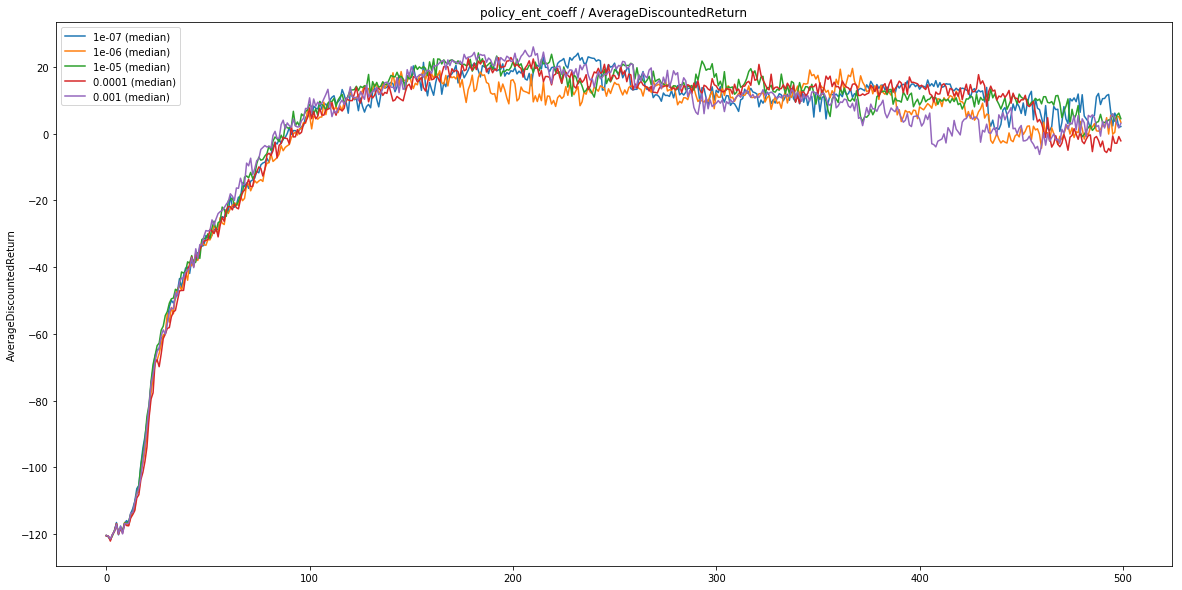

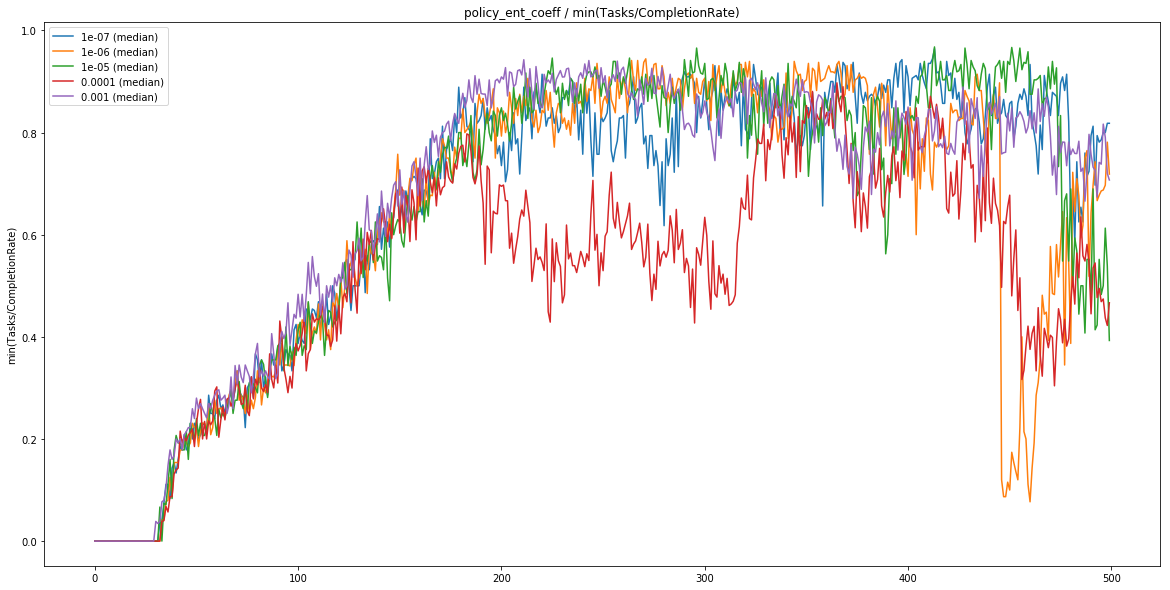

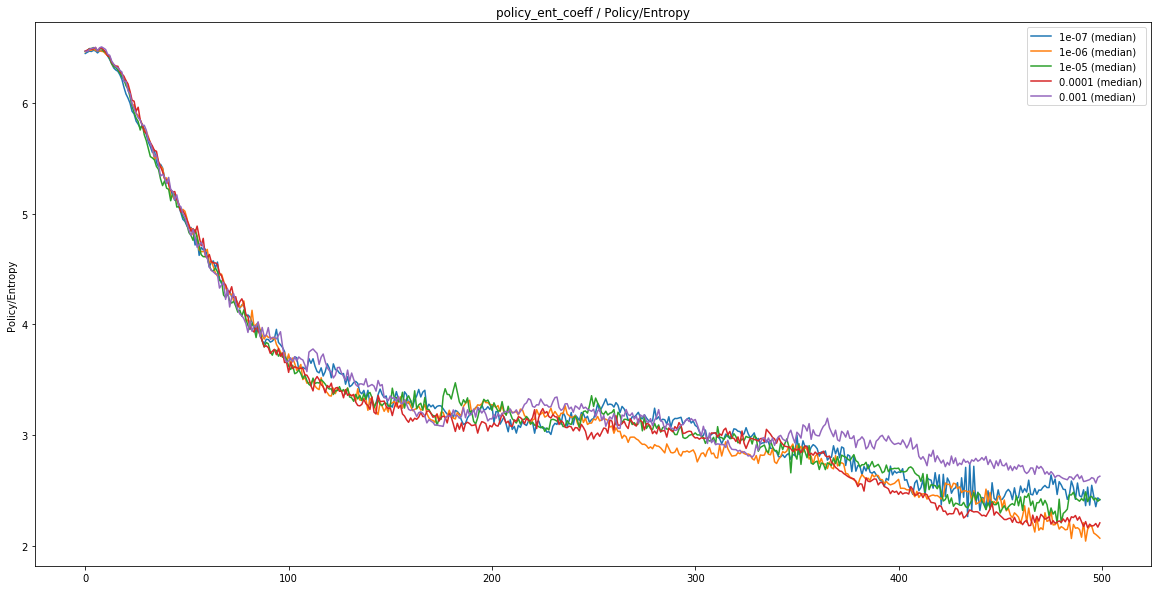

In [176]:
# Plot by policy_ent_coeff
pec_data = plot_data.groupby("policy_ent_coeff")
fig, ax = plt.subplots(figsize=(20,10))
fig2,ax2 = plt.subplots(figsize=(20,10))
fig3,ax3 = plt.subplots(figsize=(20,10))
for pec in sorted(pec_data.groups.keys()):
    maxs = pec_data.get_group(pec).groupby("Iteration").max()
    mins = pec_data.get_group(pec).groupby("Iteration").min()
    means = pec_data.get_group(pec).groupby("Iteration").mean()
    medians = pec_data.get_group(pec).groupby("Iteration").median()
    
    # AverageDiscountedReturn
    ax.plot(medians.index, medians["AverageDiscountedReturn"], label="{} (median)".format(str(pec)))
    ax.set_title("policy_ent_coeff / AverageDiscountedReturn")
    ax.set_ylabel("AverageDiscountedReturn")
    ax.legend()
    
    # min(CompletionRate)
    min_mean_comp_rate = medians[["Tasks/CompletionRate/t=0", 
                                  "Tasks/CompletionRate/t=1", 
                                  "Tasks/CompletionRate/t=2", 
                                  "Tasks/CompletionRate/t=3"]].min(axis=1)
    ax2.plot(means.index, min_mean_comp_rate, label="{} (median)".format(str(pec)))
    ax2.set_title("policy_ent_coeff / min(Tasks/CompletionRate)")
    ax2.set_ylabel("min(Tasks/CompletionRate)")
    ax2.legend()
    
    # Policy/Entropy
    ax3.plot(medians.index, medians["Policy/Entropy"], label="{} (median)".format(str(pec)))
    ax3.set_title("policy_ent_coeff / Policy/Entropy")
    ax3.set_ylabel("Policy/Entropy")
    ax3.legend()

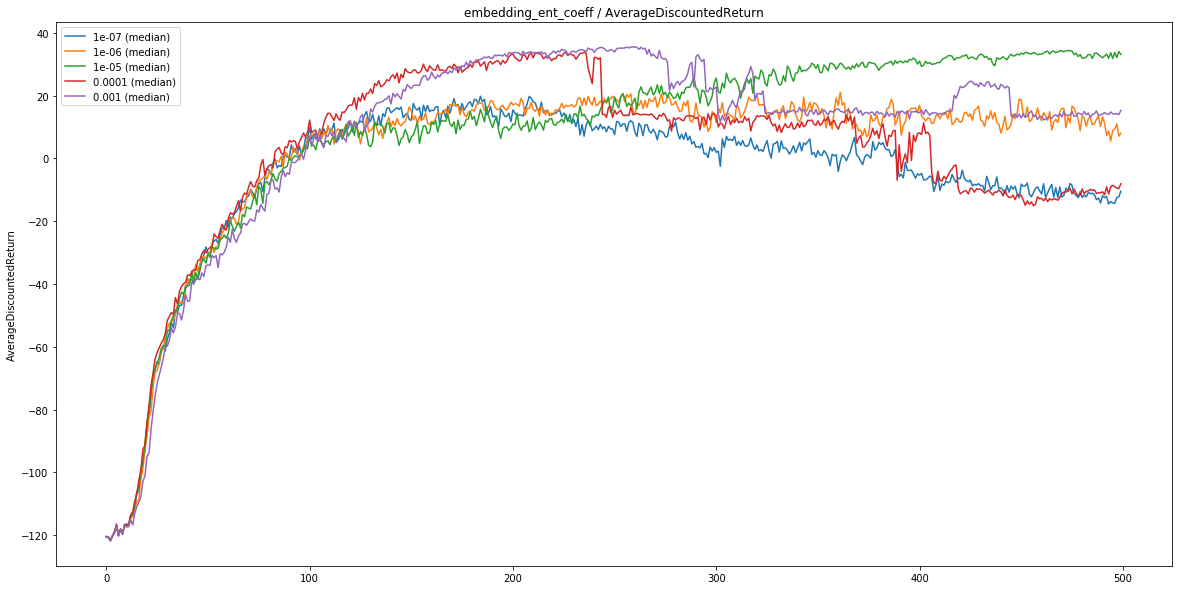

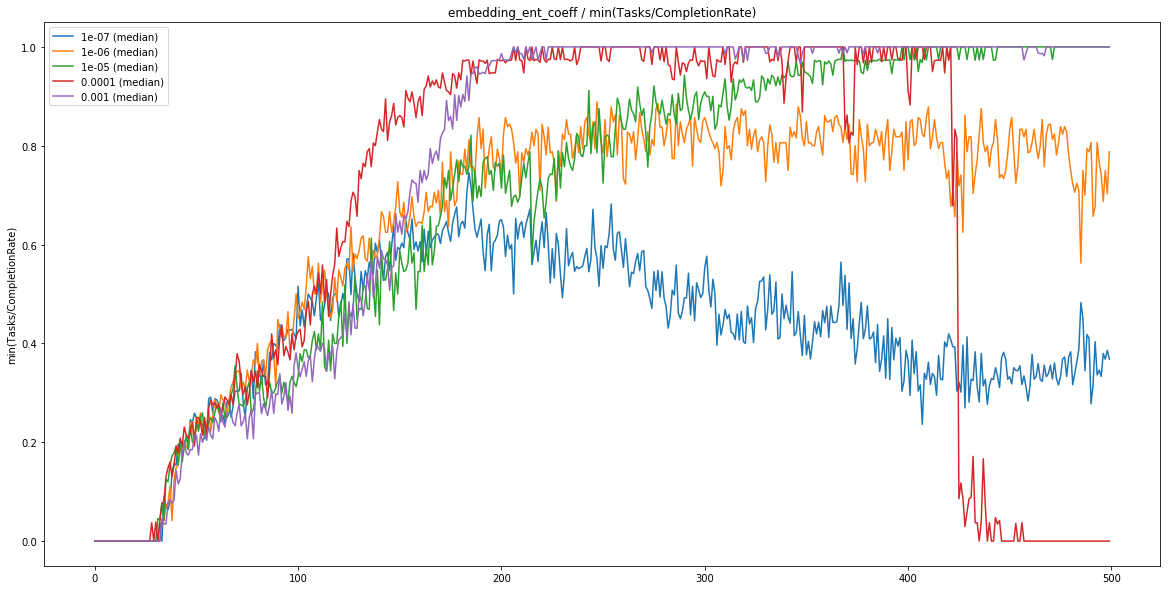

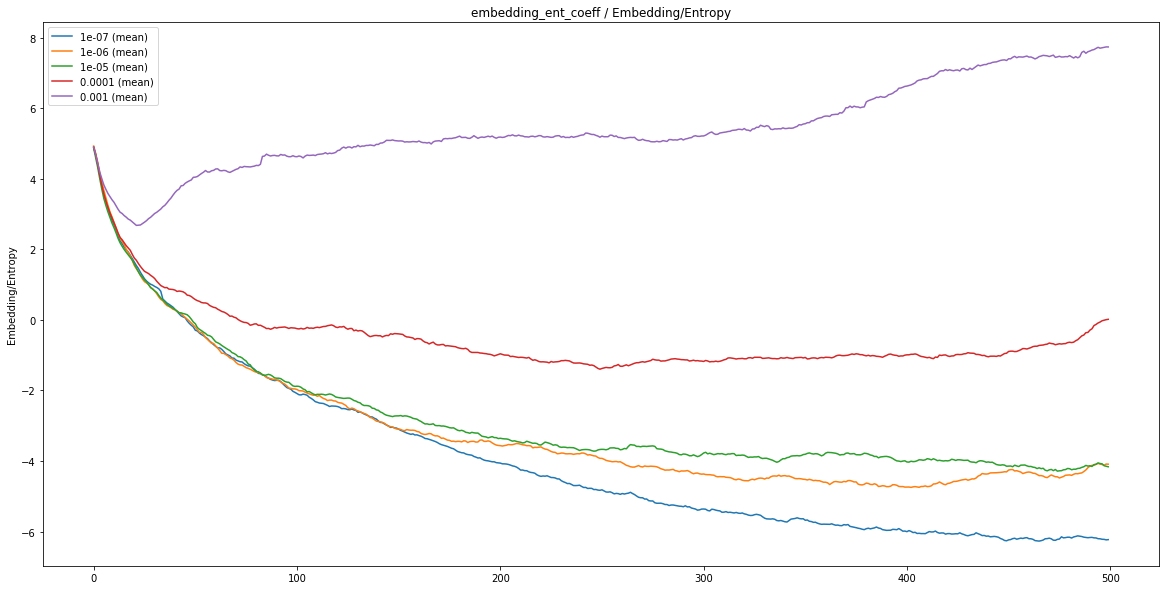

In [177]:
# Plot by embedding_ent_coeff
fig, ax = plt.subplots(figsize=(20,10))
fig2, ax2 = plt.subplots(figsize=(20,10))
fig3, ax3 = plt.subplots(figsize=(20,10))
eec_data = plot_data.groupby("embedding_ent_coeff")
for eec in sorted(eec_data.groups.keys()):
    means = eec_data.get_group(eec).groupby("Iteration").mean()
    maxs = eec_data.get_group(eec).groupby("Iteration").max()
    mins = eec_data.get_group(eec).groupby("Iteration").min()
    medians = eec_data.get_group(eec).groupby("Iteration").median()
    
    # AverageDiscountedReturn
    ax.plot(medians.index, medians["AverageDiscountedReturn"], label="{} (median)".format(str(eec)))
    ax.set_title("embedding_ent_coeff / AverageDiscountedReturn")
    ax.set_ylabel("AverageDiscountedReturn")
    ax.legend()
    
    # min(CompletionRate)
    min_mean_comp_rate = medians[["Tasks/CompletionRate/t=0", 
                                  "Tasks/CompletionRate/t=1", 
                                  "Tasks/CompletionRate/t=2", 
                                  "Tasks/CompletionRate/t=3"]].min(axis=1)
    ax2.plot(means.index, min_mean_comp_rate, label="{} (median)".format(str(eec)))
    ax2.set_title("embedding_ent_coeff / min(Tasks/CompletionRate)")
    ax2.set_ylabel("min(Tasks/CompletionRate)")
    ax2.legend()
    
    # Embedding/Entropy
    ax3.plot(means.index, means["Embedding/Entropy"], label="{} (mean)".format(str(eec)))
    ax3.set_title("embedding_ent_coeff / Embedding/Entropy")
    ax3.set_ylabel("Embedding/Entropy")
    ax3.legend()

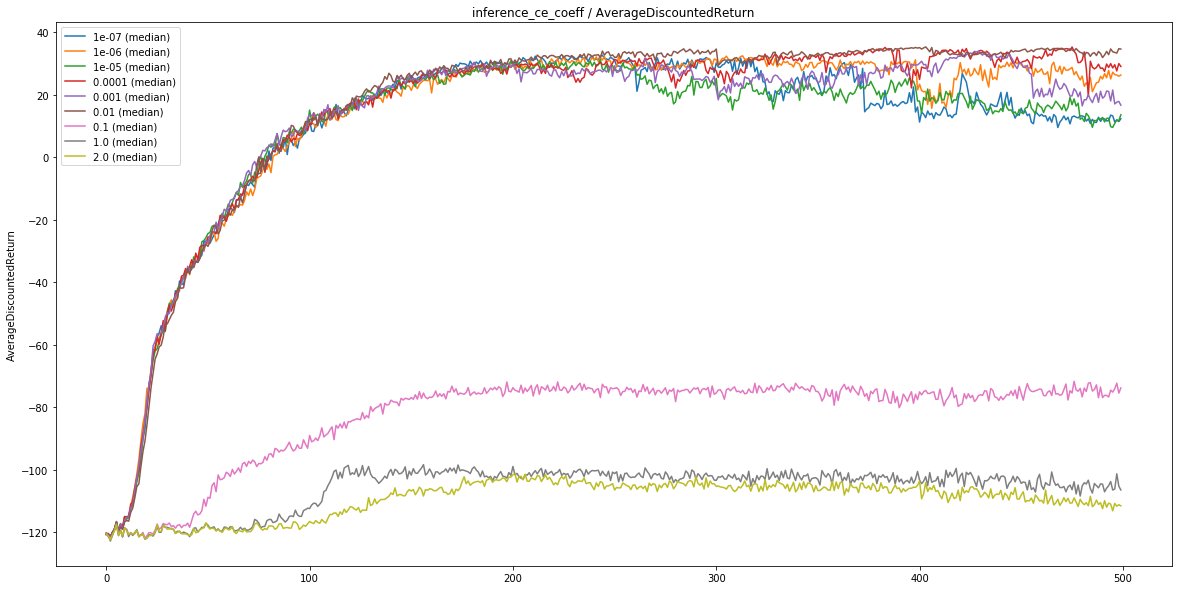

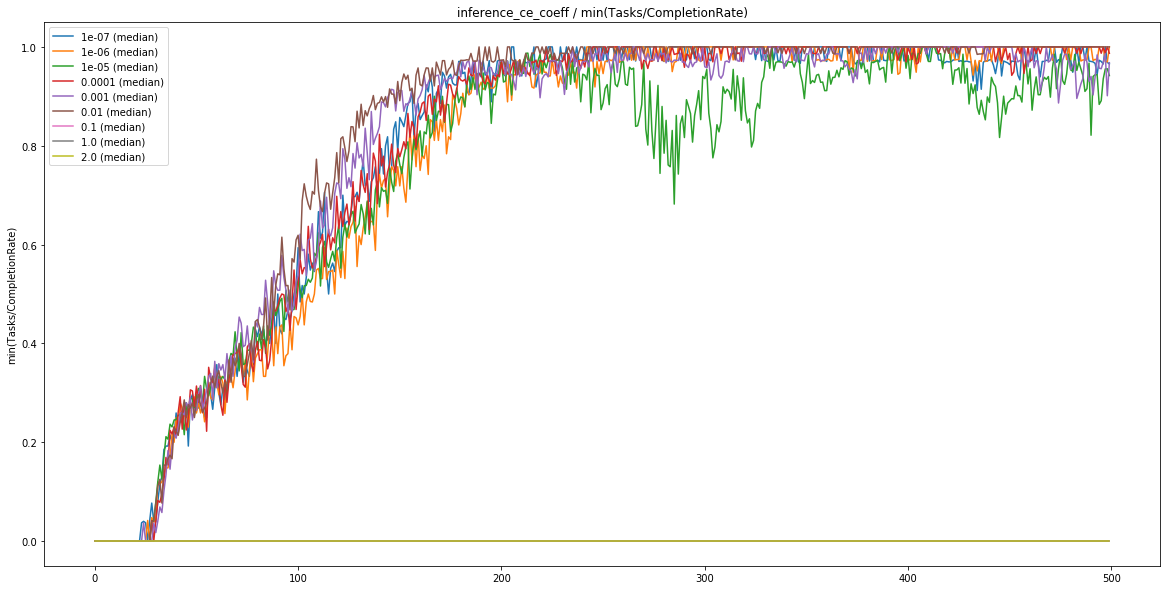

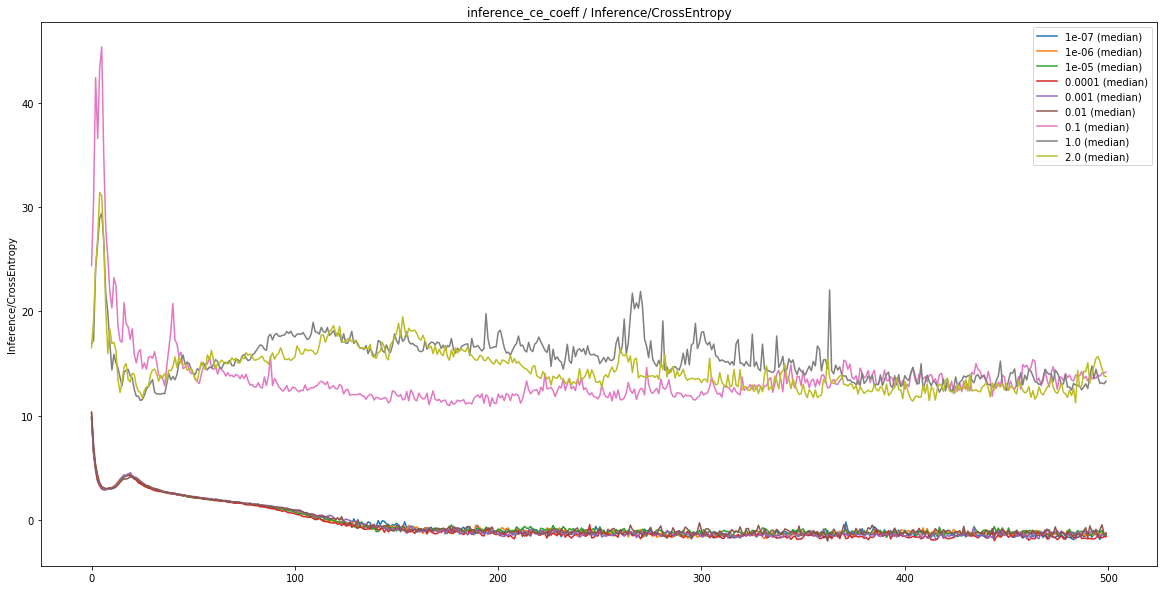

In [178]:
# Plot by inference_ce_coeff
fig, ax = plt.subplots(figsize=(20,10))
fig2, ax2 = plt.subplots(figsize=(20,10))
fig3, ax3 = plt.subplots(figsize=(20,10))
icc_data = plot_data.groupby("inference_ce_coeff")
for icc in sorted(icc_data.groups.keys()):
    means = icc_data.get_group(icc).groupby("Iteration").mean()
    maxs = icc_data.get_group(icc).groupby("Iteration").max()
    mins = icc_data.get_group(icc).groupby("Iteration").min()
    medians = icc_data.get_group(icc).groupby("Iteration").median()
    
    # AverageDiscountedReturn
    ax.plot(medians.index, medians["AverageDiscountedReturn"], label="{} (median)".format(str(icc)))
    ax.set_title("inference_ce_coeff / AverageDiscountedReturn")
    ax.set_ylabel("AverageDiscountedReturn")
    ax.legend()
    
    # min(CompletionRate)
    min_mean_comp_rate = medians[["Tasks/CompletionRate/t=0", 
                                  "Tasks/CompletionRate/t=1", 
                                  "Tasks/CompletionRate/t=2", 
                                  "Tasks/CompletionRate/t=3"]].min(axis=1)
    ax2.plot(medians.index, min_mean_comp_rate, label="{} (median)".format(str(icc)))
    ax2.set_title("inference_ce_coeff / min(Tasks/CompletionRate)")
    ax2.set_ylabel("min(Tasks/CompletionRate)")
    ax2.legend()
    
    # Inference/CrossEntropy
    ax3.plot(medians.index, medians["Inference/CrossEntropy"], label="{} (median)".format(str(icc)))
    ax3.set_title("inference_ce_coeff / Inference/CrossEntropy")
    ax3.set_ylabel("Inference/CrossEntropy")
    ax3.legend()